In [90]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel
from scipy.stats import norm

# create meshgrid
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)
x1m, x2m = np.meshgrid(x1, x2)
X_mesh = np.vstack((x1m.flatten(), x2m.flatten())).T

In [91]:
x_start = [[-0.5, -np.sqrt(3)*0.5/3], [0.5, -np.sqrt(3)*0.5/3], [0,np.sqrt(3)*0.5*2/3], [0, 0]]

(-1.0, 1.0)

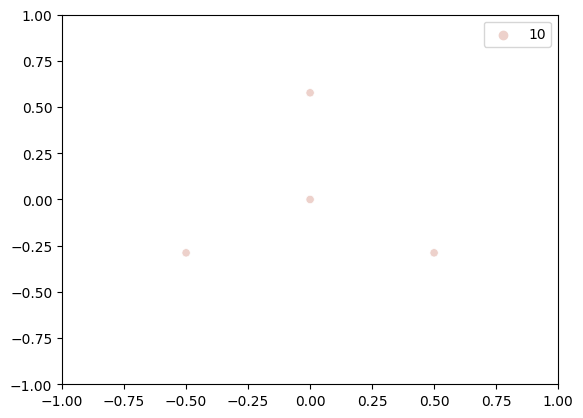

In [92]:
X = np.array(x_start)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
plt.xlim(-1,1)
plt.ylim(-1,1)

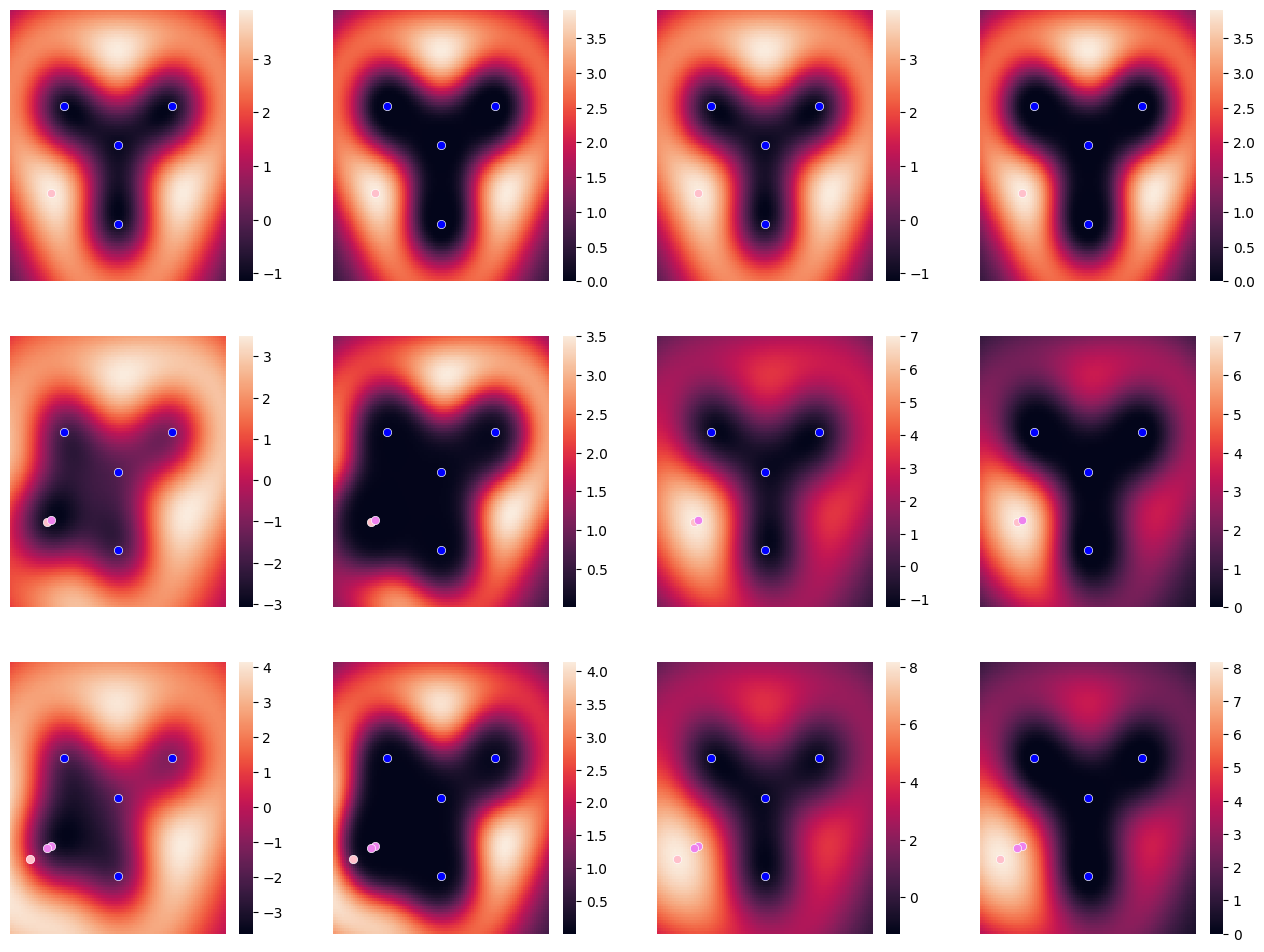

In [93]:
mu_sample_opt = 10
iterations = 3

xi = 1

fig, ax = plt.subplots(iterations, 4, figsize=(16, iterations*4))
kernel_self = (
    RBF(length_scale=0.3, length_scale_bounds='fixed') + 
    ConstantKernel(0, constant_value_bounds='fixed')
)
kernel_other = (
    RBF(length_scale=0.3, length_scale_bounds='fixed') + 
    ConstantKernel(0, constant_value_bounds='fixed')
)
kernel_all = (
    RBF(length_scale=0.5, length_scale_bounds='fixed') + 
    ConstantKernel(0, constant_value_bounds='fixed')
)

def mesh_values_to_df(array, x1, x2):
    return pd.DataFrame(array.reshape(len(x1), len(x2)), index=x1, columns=x2)


x_self = []
x_other = x_start
for i in range(iterations):
    x_all = x_start + x_self
    gp = GaussianProcessRegressor(kernel=kernel_other, n_restarts_optimizer=9)
    x_other_np = np.array(x_other)
    gp = gp.fit(x_other_np, np.full(len(x_other), fill_value=10))
    y_mean_other, y_std_other = gp.predict(X_mesh, return_std=True)

    if len(x_self) > 0:
        gp = GaussianProcessRegressor(kernel=kernel_other, n_restarts_optimizer=9)
        x_self_np = np.array(x_self)
        gp = gp.fit(x_self_np, np.full(len(x_self), fill_value=10))
        y_mean_self, y_std_self = gp.predict(X_mesh, return_std=True)
    else:
        y_mean_self = np.zeros_like(y_mean_other)
        y_std_self = np.zeros_like(y_std_other)

    gp = GaussianProcessRegressor(kernel=kernel_all, n_restarts_optimizer=9)
    x_all_np = np.array(x_all)
    gp = gp.fit(x_all_np, np.full(len(x_all), fill_value=10))
    y_mean_all, y_std_all = gp.predict(X_mesh, return_std=True)

    imp_self = y_mean_all - y_mean_other - xi
    y_std = np.sqrt(y_std_all**2 + y_std_other**2)
    Z = imp_self / y_std
    ei_self = imp_self * norm.cdf(Z) + y_std * norm.pdf(Z)
    ei_self[y_std == 0.0] = 0.0

    imp_all = y_mean_all - y_mean_other - y_mean_self - xi
    y_std = np.sqrt(y_std_all**2 + y_std_other**2 + y_std_self**2)
    Z = imp_all / y_std
    ei_all = imp_all * norm.cdf(Z) + y_std * norm.pdf(Z)
    ei_all[y_std == 0.0] = 0.0

    x_next = X_mesh[np.argmax(ei_self)]
    mesh_size = int(np.sqrt(X_mesh.shape[0]))
    sns.heatmap(mesh_values_to_df(imp_all, x1, x2), ax=ax[i,0], yticklabels=False, xticklabels=False)
    sns.heatmap(mesh_values_to_df(ei_all, x1, x2), ax=ax[i,1], yticklabels=False, xticklabels=False)
    sns.heatmap(mesh_values_to_df(imp_self, x1, x2), ax=ax[i,2], yticklabels=False, xticklabels=False)
    sns.heatmap(mesh_values_to_df(ei_self, x1, x2), ax=ax[i,3], yticklabels=False, xticklabels=False)
    for j in range(4):
        sns.scatterplot(x=(x_other_np[:,0]+1)*50, y=(x_other_np[:,1]+1)*50, ax=ax[i,j], color='blue')
        sns.scatterplot(x=(x_next[np.newaxis,0]+1)*50, y=(x_next[np.newaxis,1]+1)*50, ax=ax[i,j], color='pink')
        if len(x_self) > 0:
            sns.scatterplot(x=(x_self_np[:,0]+1)*50, y=(x_self_np[:,1]+1)*50, ax=ax[i,j], color='violet')
    x_self.append(x_next.tolist())